core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']


=== Race Results (Top 10) ===
    Position Abbreviation         FullName         TeamName    Status
1        1.0          VER   Max Verstappen  Red Bull Racing  Finished
44       2.0          HAM   Lewis Hamilton         Mercedes  Finished
14       3.0          ALO  Fernando Alonso     Aston Martin  Finished
18       4.0          STR     Lance Stroll     Aston Martin  Finished
11       5.0          PER     Sergio Perez  Red Bull Racing  Finished
4        6.0          NOR     Lando Norris          McLaren  Finished
27       7.0          HUL  Nico Hulkenberg     Haas F1 Team  Finished
81       8.0          PIA    Oscar Piastri          McLaren  Finished
24       9.0          ZHO      Guanyu Zhou       Alfa Romeo  Finished
22      10.0          TSU     Yuki Tsunoda       AlphaTauri  Finished

=== Hamilton Lap Times (first 10 laps) ===
     LapNumber                LapTime
753        1.0 0 days 00:01:40.229000
754        2.0 0 days 00:02:12.287000
755        3.0 0 days 00:02:11.362000
756 

c:\Users\Mahir Kardame\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


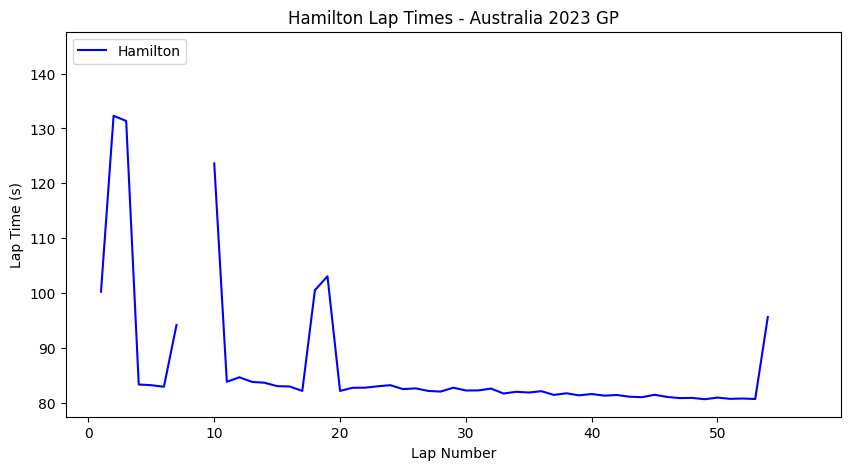

c:\Users\Mahir Kardame\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"



=== Verstappen Tyre Stints ===
   Stint Compound  LapStart  LapEnd
0    1.0   MEDIUM       1.0     8.0
1    2.0     HARD       9.0    55.0
2    3.0     SOFT      56.0    57.0
3    4.0     SOFT      58.0    58.0


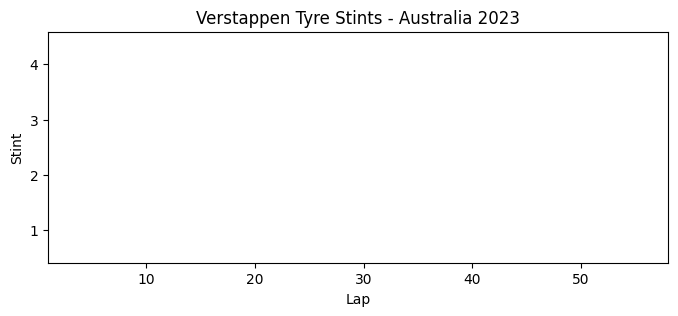


=== Weather Data (first 5 laps) ===
                    Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0 0 days 00:00:35.812000     17.1      53.0    1018.5     False       35.0   
1 0 days 00:01:35.812000     17.2      52.0    1018.7     False       35.1   
2 0 days 00:02:35.811000     17.2      52.0    1018.7     False       35.1   
3 0 days 00:03:35.826000     17.3      51.0    1018.7     False       35.1   
4 0 days 00:04:35.825000     17.3      51.0    1018.7     False       34.8   

   WindDirection  WindSpeed  
0              0        1.6  
1              0        0.8  
2            168        0.6  
3              8        0.8  
4            200        0.8  

=== Safety Car Data ===


AttributeError: 'Session' object has no attribute 'safety_car'

In [ ]:
# ================================
# FastF1 + RAG Example: Australia 2023 GP
# ================================

import os
import pandas as pd
import fastf1
import fastf1.plotting
import matplotlib.pyplot as plt

# 1. Enable cache (creates folder if missing)
os.makedirs("fastf1_cache", exist_ok=True)
fastf1.Cache.enable_cache("fastf1_cache")

# ================================
# Load Sessions
# ================================
race = fastf1.get_session(2023, "Australia", "R")
race.load()

quali = fastf1.get_session(2023, "Australia", "Q")
quali.load()

# ================================
# Race Results
# ================================
results = race.results[["Position", "Abbreviation", "FullName", "TeamName", "Status"]]
print("=== Race Results (Top 10) ===")
print(results.head(10))

# Convert results to text for RAG
race_results_text = "\n".join([
    f"P{row.Position}: {row.FullName} ({row.Abbreviation}) - {row.TeamName}, Status: {row.Status}"
    for _, row in results.iterrows()
])

# ================================
# Example: Hamilton Lap Times
# ================================
hamilton = race.laps.pick_driver("HAM")
print("\n=== Hamilton Lap Times (first 10 laps) ===")
print(hamilton[["LapNumber", "LapTime"]].head(10))

plt.figure(figsize=(10, 5))
plt.plot(hamilton["LapNumber"], hamilton["LapTime"].dt.total_seconds(), label="Hamilton", color="blue")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (s)")
plt.title("Hamilton Lap Times - Australia 2023 GP")
plt.legend()
plt.show()

# Convert Hamilton lap times into text
ham_laps_text = "\n".join([
    f"Lap {row.LapNumber}: {row.LapTime}" for _, row in hamilton.head(10).iterrows()
])

# ================================
# Tyre Stints (fixed) for Verstappen
# ================================
verstappen_laps = race.laps.pick_driver("VER")
verstappen_stints = verstappen_laps.groupby(["Stint"]).agg(
    Compound=("Compound", "first"),
    LapStart=("LapNumber", "min"),
    LapEnd=("LapNumber", "max")
).reset_index()

print("\n=== Verstappen Tyre Stints ===")
print(verstappen_stints)

fig, ax = plt.subplots(figsize=(8, 3))
ax.barh(
    verstappen_stints["Stint"],
    verstappen_stints["LapEnd"] - verstappen_stints["LapStart"],
    left=verstappen_stints["LapStart"],
    color=["yellow" if c == "M" else "red" if c == "S" else "white" for c in verstappen_stints["Compound"]]
)
ax.set_xlabel("Lap")
ax.set_ylabel("Stint")
ax.set_title("Verstappen Tyre Stints - Australia 2023")
plt.show()

# Convert stints into text
stints_text = "\n".join([
    f"Stint {row.Stint}: {row.Compound} from lap {row.LapStart} to {row.LapEnd}"
    for _, row in verstappen_stints.iterrows()
])

# ================================
# Weather Data
# ================================
print("\n=== Weather Data (first 5 laps) ===")
print(race.weather_data.head())

weather_text = "\n".join([
    f"Lap {row.Index}: Temp {row.AirTemp}°C, Track {row.TrackTemp}°C, Humidity {row.Humidity}%"
    for row in race.weather_data.head().itertuples()
])

# ================================
# Safety Car / VSC
# ================================
print("\n=== Safety Car Data ===")
print(race.safety_car)

sc_text = "\n".join([
    f"SC from {row.StartLap} to {row.EndLap}" for _, row in race.safety_car.iterrows()
]) if not race.safety_car.empty else "No Safety Car periods."

# ================================
# Qualifying + 107% Rule
# ================================
quali_results = quali.results[["Position", "Abbreviation", "Q1", "Q2", "Q3"]]
print("\n=== Qualifying Results (Top 10) ===")
print(quali_results.head(10))

q1_times = quali.results[["Abbreviation", "Q1"]].dropna()
q1_times["Q1"] = pd.to_timedelta(q1_times["Q1"])
fastest = q1_times["Q1"].min()
threshold = fastest * 1.07
violations = q1_times[q1_times["Q1"] > threshold]

print("\n=== 107% Rule Violations ===")
if violations.empty:
    print("No driver outside 107% rule.")
else:
    print(violations)

# Convert quali results + 107% check into text
quali_text = "\n".join([
    f"P{row.Position}: {row.Abbreviation}, Q1={row.Q1}, Q2={row.Q2}, Q3={row.Q3}"
    for _, row in quali_results.iterrows()
])
violations_text = "No 107% violations." if violations.empty else str(violations)

# ================================
# Lap Time Comparison Plot
# ================================
plt.figure(figsize=(12, 6))
for driver in ["VER", "HAM", "LEC"]:
    laps = race.laps.pick_driver(driver)
    plt.plot(laps["LapNumber"], laps["LapTime"].dt.total_seconds(), label=driver)

plt.xlabel("Lap Number")
plt.ylabel("Lap Time (s)")
plt.title("Lap Time Comparison - Australia 2023 GP")
plt.legend()
plt.show()

# ================================
# Export to Text for RAG
# ================================
all_text_docs = {
    "race_results": race_results_text,
    "hamilton_laps": ham_laps_text,
    "verstappen_stints": stints_text,
    "weather": weather_text,
    "safety_car": sc_text,
    "qualifying": quali_text,
    "107_rule": violations_text
}

# Save to a simple .txt file
with open("fastf1_australia2023.txt", "w", encoding="utf-8") as f:
    for key, value in all_text_docs.items():
        f.write(f"## {key.upper()}\n{value}\n\n")

print("\n=== Data exported to fastf1_australia2023.txt for RAG ingestion ===")
